# Measure the instantaneous angular velocity of rotating plate

The measurement is performed by processing the recorded videos. The code
to perform the measurement is developed and tested with reference to the
first experimental repetition. The resulting code is then applied to all
repetitions.

## Import the packages and define utilities

The packages are imported with the following role:

-   `matplotlib`, scientific visualization
-   `natsort`, ordering of the frames 'naturally' (i.e., recognizing
    numbers in file names) instead of 'lexicographically'
-   `numpy`, scientific computing
-   `os`, interaction with the OS
-   `pandas`, operations on tables and databases
-   `plotly`, visualization of animations
-   `skimage`, image manipulation of the recordings frame-by-frame

In [ ]:
import numpy as np
import os
import pandas as pd
import skimage as ski

from matplotlib import pyplot as plt, patches
from natsort import natsorted
from plotly import io as pio, express as pex, graph_objects as pgo


Define a function to generate the animation associated to a sequence of
images and save it in an HTML file.

In [ ]:
def save_animation(address, image_sequence, bboxes=None, lines=None):
    fig = pex.imshow(
        image_sequence,
        animation_frame=0,
        binary_string=True,
        labels={'animation frame': 'time point'}
    )
    if bboxes is not None:
        if len(bboxes) == len(fig.frames):
            for i, frame in enumerate(fig.frames):
                frame.layout = pgo.Layout(
                    shapes = [dict(
                        type='rect',
                        x0 = bboxes[i][1],
                        y0 = bboxes[i][0],
                        x1 = bboxes[i][3],
                        y1 = bboxes[i][2],
                        line = dict(color = 'Red')
                    )]
                )
        else:
            print('Number of boxes different from the number of frames. \
            Boxes not shown')
    if lines is not None:
        if len(lines) == len(fig.frames):
            for i, frame in enumerate(fig.frames):
                frame.layout = pgo.Layout(
                    shapes = [dict(
                        type='line',
                        x0 = lines[i],
                        y0 = 0,
                        x1 = lines[i],
                        y1 = 1,
                        yref = 'paper',
                        line = dict(color = 'Green')
                    )
                    ]
                )
    pio.write_html(fig, address)


## Define the studied repetition

Define the repetition that will be processed.

In [ ]:
experiment = 'repetition 1'


## Load the sequence of images

Load all the frames of the recordings from a list of images named as
incremental numbers.

In [ ]:
folder = os.path.join(experiment, 'motion')
list_files = natsorted(os.listdir(folder))

image_sequence = []
for filename in list_files:
    address = os.path.join(folder, filename)
    frame = ski.io.imread(address, as_gray=True)
    image_sequence.append(frame)
image_sequence = np.array(image_sequence)

animation_folder = os.path.join(experiment, 'animations')
address = os.path.join(animation_folder, 'motion.html')
save_animation(address, image_sequence)


## Extract the coordinates of the fulcrum

Starting from seed points selected by hand in the first frame, the
region of contact between the plate and the ground is identified with a
flood algorithm.

In [ ]:
if experiment == 'repetition 1':
    seed_points = [(319, 813), (126, 808)]
    tolerances = [0.1, 0.036]
elif experiment == 'repetition 2':
    seed_points = [(390, 815),]
    tolerances = [0.06,]
elif experiment == 'repetition 3':
    seed_points = [(238, 810),]
    tolerances = [0.05,]
elif experiment == 'repetition 4':
    seed_points = [(390, 815),]
    tolerances = [0.05,]
elif experiment == 'repetition 5':
    seed_points = [(238, 810), (390, 815)]
    tolerances = [0.04,0.06]

image_fulcrum = np.zeros_like(image_sequence[0, ...])
for seed_point, tolerance in zip(seed_points, tolerances):
    image_fulcrum += ski.segmentation.flood(image_sequence[0, ...],
                                           seed_point, tolerance=tolerance)

indexes = np.argwhere(image_fulcrum)
(y0, x0) = indexes.min(0)
(y1, x1) = indexes.max(0) + 1

plt.figure()
plt.imshow(image_sequence[0, ...], cmap=plt.cm.Grays_r)
plt.imshow(image_fulcrum, cmap=plt.cm.Reds, alpha=0.8)
plt.gca().add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                      facecolor='none', edgecolor='red'))
plt.show()


The fulcrum should be a vertical line. We can use the found coordinates
to rotate the images and correct the angle of acquisition.

In [ ]:
angle = np.rad2deg(np.atan((x1-x0)/(y0-y1)))

print('The camera angle is corrected by {:.1f}°'.format(angle))

corrected_sequence = np.empty_like(image_sequence)
for frame_index in range(image_sequence.shape[0]):
    frame = image_sequence[frame_index, ...]
    corrected_sequence[frame_index, ...] = ski.transform.rotate(frame, angle)

address = os.path.join(animation_folder, 'corrected_motion.html')
save_animation(address, corrected_sequence)


Starting again from a seed point selected by hand in the first frame,
the region of contact between the plate and the ground is identified
again with a flood algorithm.

In [ ]:
if experiment == 'repetition 1':
    seed_points = [(339, 815), (83, 818)]
    tolerances = [0.08, 0.07]
elif experiment == 'repetition 2' \
     or experiment == 'repetition 3' \
     or experiment == 'repetition 4' \
     or experiment == 'repetition 5':
    seed_points = [(341, 815),]
    tolerances = [0.08,]

corrected_fulcrum = np.zeros_like(corrected_sequence[0, ...])
for seed_point, tolerance in zip(seed_points, tolerances):
    corrected_fulcrum += ski.segmentation.flood(corrected_sequence[0, ...],
                                                seed_point, tolerance=tolerance)

indexes = np.argwhere(corrected_fulcrum)
(y0, x0) = indexes.min(0)
(y1, x1) = indexes.max(0) + 1

plt.figure()
plt.imshow(corrected_sequence[0, ...], cmap=plt.cm.Grays_r)
plt.imshow(corrected_fulcrum, cmap=plt.cm.Reds, alpha=0.8)
plt.gca().add_patch(patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                      facecolor='none', edgecolor='red'))
plt.show()


The fulcrum coordinate is well estimated as the average x-coordinate of
the box and half box side provides its uncertainty.

In [ ]:
fulcrum_x = (x0 + x1) / 2
fulcrum_x_unc = np.abs(x0 - x1) / 2

print(f'Fulcrum coordinate is {fulcrum_x} px +- {fulcrum_x_unc} px')


## Extract the height of the plate in each frame

To estimate the apparent height of the plate in each frame, we must
identify the coordinate of its upper edge (on the left in the images).

### Compute the image deltas

Image deltas allow to detect only what changed from one frame to
another. The deltas are saturated at the first percentile of the frame
in order to remove the acquisition noise.

In [ ]:
image_deltas = corrected_sequence[1:, ...] - corrected_sequence[:-1, ...]

half_pixels = image_deltas.shape[1] * image_deltas.shape[2] / 2.0
binarized = np.empty(image_deltas.shape, dtype=bool)
for frame_index in range(image_deltas.shape[0]):
    frame = image_deltas[frame_index, ...]
    threshold = np.percentile(image_deltas[frame_index, ...], 1)
    binarized[frame_index, ...] = frame < threshold
    if np.count_nonzero(binarized[frame_index, ...]) > half_pixels:
        binarized[frame_index, ...] = np.logical_not(binarized[frame_index, ...])

address = os.path.join(animation_folder, 'deltas.html')
save_animation(address, binarized)


### Select the bounding box of the change due to the moving edge

The moving edge covers an area that is identified by looking for the
largest connected region in each image delta.

In [ ]:
largest_regions = np.zeros_like(binarized)
bboxes = []
for frame_index in range(binarized.shape[0]):
    frame = binarized[frame_index, ...]
    labels = ski.measure.label(frame)
    regionprops = ski.measure.regionprops_table(labels, properties=('label',
                                                                    'area',
                                                                    'bbox'))
    regionprops = pd.DataFrame(regionprops)
    if not regionprops.empty:
        regionprops.sort_values('area', ascending=False, inplace=True)
        largest_regions[frame_index, ...] = labels == regionprops.iloc[0]['label']
        bboxes.append([regionprops.iloc[0][f'bbox-{i}'] for i in range(4)])
    else:
        bboxes.append([0, 0, 0, 0])

grayscale_selection = largest_regions.astype(float) + binarized.astype(float)
address = os.path.join(animation_folder, 'largest_areas.html')
save_animation(address, grayscale_selection, bboxes=bboxes)


### Check the obtained guess of the upper edge locations

In each interval between two frames, the bounding box of the largest
connected area is extended from the position of the edge at the
beginning of the time interval to the position at the end of the time
interval.

In [ ]:
edges_l = np.array([bboxes[i][1] for i in range(len(bboxes))])
edges_r = np.array([bboxes[i][3] for i in range(len(bboxes))])

edges = np.zeros((corrected_sequence.shape[0],))
edges[:-1] = edges_l
edges[1:] += edges_r
edges[1:-1] /= 2.0

address = os.path.join(animation_folder, 'edges_first_guess.html')
save_animation(address, corrected_sequence, lines=edges)


### Correct the edge locations in the frames where the automatic method failed

For repetition 1, the upper edge is located wrongly in first two frames.
A small imperfection can also be recognized in the last four frames.
These 6 values are corrected by hand, looking from a reasonable
locations in the images.

This correction is repeated by hand for each repetition.

In [ ]:
if experiment == 'repetition 1':
    edges[0] = 120
    edges[1] = 132
    edges[-4] = 816
    edges[-3] = 834
    edges[-2] = 852
    edges[-1] = 870
elif experiment == 'repetition 2':
    edges[0] = 120
    edges[1] = 126
    edges[-4] = 827
    edges[-3] = 845
    edges[-2] = 863
    edges[-1] = 878
elif experiment == 'repetition 3':
    edges[-7] = 772
    edges[-6] = 790
    edges[-5] = 807
    edges[-4] = 825
    edges[-3] = 844
    edges[-2] = 861
    edges[-1] = 877
elif experiment == 'repetition 4':
    edges[0] = 120
    edges[1] = 132
    edges[-3] = 832
    edges[-2] = 850
    edges[-1] = 868
elif experiment == 'repetition 5':
    edges[0] = 119
    edges[1] = 127
    edges[-4] = 826
    edges[-3] = 844
    edges[-2] = 862

address = os.path.join(animation_folder, 'edges_final_guess.html')
save_animation(address, corrected_sequence, lines=edges)


## Transform the extracted fulcrum and edge locations in angles

This transformation is based on the assumption that the observer's eye
performs a projection of the 3D objects in front of him on a 2D plane.
The image captured by the camera is the result of this projection.

Let us consider the setup represented in the following diagram:

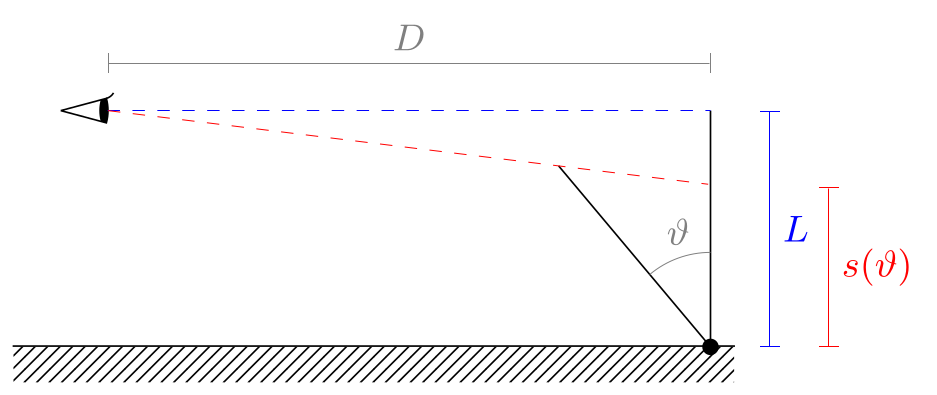

According to it, when the plate is fallen of an angle $\vartheta$, its
height in the picture is $s(\vartheta)$ instead of $L$. In a reference
system with origin in the fulcrum, we have the tip of the plate in
$L*(-\sin(\vartheta), \cos(\vartheta))$ and the observed at $(-D, L)$.
The line connecting these two points is
$$y - L = \frac{L \cos(\vartheta) - L}{-L \sin(\vartheta) + D} (x + D)\,,$$
that in $x = 0$ leads to
$$s(\vartheta) = \frac{L \cos(\vartheta) - L}{-L \sin(\vartheta) + D} D + L\,.$$
Moreover, it is worth noting that $s(0) = L$, so that $L$ can be
estimated in the pixel unit of the recording as the length of the plate
in the first frame. If the initial angle $\vartheta_0$ is small but
different from $0$, we can write the approximated equation
$s(\vartheta_0) = L \cos(\vartheta_0)$, from which $L$ is estimated.

The length of the plate in the last frame (which is negative with
respect to the location of the fulcrum) provides an information
regarding $D$. Precisely, in the last frame the plate is completely
fallen, so $\vartheta = 90°$, and
$$s(90°) = \frac{-L}{D - L} D + L = L \left( 1 + \frac{D}{L - D} \right)\,.$$
By inverting the latter equation, we get the expression
$$d = L \frac{s(90°) - L}{s(90°)}$$

Going back to the starting equation, for any $\vartheta$, we have
$$\frac{s(\vartheta)}{L} - 1 = \frac{\cos(\vartheta) - 1}{D - \sin(\vartheta) L} D\,,$$
that must be inverted with respect to $\vartheta$, for example using a
look-up table.

In [ ]:
theta_0 = np.deg2rad(3.0)

s = fulcrum_x - edges
L = s[0] / np.cos(theta_0)
d = L * (s[-1] - L) / s[-1]

print('L = {:.2f} px, D = {:.2f} px'.format(L, d))


The output is stored in a CSV file providing the trend in time of the
angle of the falling plate.

In [ ]:
theta_p = np.linspace(0, np.deg2rad(90), 91)
theta_p = theta_p[::-1]
s_p = L * (d * (np.cos(theta_p) - 1) / (d - np.sin(theta_p) * L) + 1)

theta = np.interp(s, s_p, theta_p)

times = np.arange(corrected_sequence.shape[0]) / 1.0

plt.figure()
plt.plot(times, np.rad2deg(theta))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title(f"Trajectory of the falling plate - {experiment}")
plt.show()

address = os.path.join(experiment, 'trajectory.csv')
with open(address, 'w') as ofile:
    ofile.write('#time(s),angle(deg)\n')
    for i in range(len(theta)):
        x = times[i]
        y = np.rad2deg(theta[i])
        ofile.write(f'{x},{y}\n')
